In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Dec 20 11:11:41 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0              46W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [4]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


# Libraries

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#thread and progress bar
import concurrent.futures
from tqdm import tqdm

#preprocessing
import string
import re
string.punctuation
from nltk import bigrams
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
nltk.download('stopwords')

#plotting the data
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer

#Model
from transformers import BertTokenizer, BertModel, TFBertModel, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
import gc

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Understanding BERT

This is just to show and understand the inner working of BERT transformer but won't be used as model for our data as BERT is already pre-trained and would be a waste to not take advantage of it

![BERT Schéma](https://drive.google.com/uc?export=view&id=1Iu_rP2pKieoOhe6xeKxVtlk0PCXGFXzN)


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

In [7]:
class SimpleSelfAttention(torch.nn.Module):
    def __init__(self, embed_size):
        super(SimpleSelfAttention, self).__init__()
        self.embed_size = embed_size

        self.query_projection = nn.Linear(embed_size, embed_size)
        self.key_projection = nn.Linear(embed_size, embed_size)
        self.value_projection = nn.Linear(embed_size, embed_size)

        self.linear = nn.Linear(embed_size, embed_size)
        self.relu = nn.ReLU()

        self.layer_norm1 = nn.LayerNorm(embed_size)
        self.layer_norm2 = nn.LayerNorm(embed_size)

    def forward(self, x):
        # Project the input to obtain queries, keys, and values
        queries = self.query_projection(x)
        keys = self.key_projection(x)
        values = self.value_projection(x)

        # Compute scaled dot-product attention
        attention_scores = torch.matmul(queries, keys.transpose(-2, -1))
        attention_scores = attention_scores / np.sqrt(self.embed_size)
        attention_weights = F.softmax(attention_scores, dim=-1)

        # Apply attention to values
        output = torch.matmul(attention_weights, values)

        # Add & Norm Layer
        output = self.layer_norm1(x + output)

        # Additional feedforward layer with ReLU activation
        output = self.linear(self.relu(self.linear(output)))

        # Add & Norm Layer
        output = self.layer_norm2(x + output)

        return output

class SimpleSelfAttentionClassifier(torch.nn.Module):
    def __init__(self, embed_size, num_classes):
        super(SimpleSelfAttentionClassifier, self).__init__()
        self.self_attention = SimpleSelfAttention(embed_size)
        self.classification = nn.Linear(embed_size, num_classes)

    def forward(self, x):
        # Apply self-attention
        attention_output = self.self_attention(x)

        # Global average pooling to get a fixed-size representation
        pooled_output = attention_output.mean(dim=1)

        # Classification layer
        logits = self.classification(pooled_output)
        return logits

In [8]:
embed_size = 64 #each token is a 64-d vector

# Create an instance of the model
attention_model = SimpleSelfAttention(embed_size)

# Example input
batch_size = 16 #during one iteration, 16 training examples simultaneously
sequence_length = 10
input_data = torch.randn(batch_size, sequence_length, embed_size)

# Forward pass through the attention model
output = attention_model(input_data)

print("Input shape:", input_data.shape)
print("Output shape:", output.shape)


Input shape: torch.Size([16, 10, 64])
Output shape: torch.Size([16, 10, 64])


# Dataset Exploration



In [9]:
snopes_df = pd.read_csv('drive/MyDrive/Colab Notebooks/TB/snopes_corpus_4.csv')

In [10]:
snopes_df.head()

,ID,Snopes URL,Claim,Truthfulness (Verdicts),Snippets (ETS),Source URL,Source,Documents (orginal documents),Match ETS and Documents
0,1,http://www.snopes.com/inboxer/prayer/darkhorse...,Prayers are requested for the Darkhorse Marine...,OUTDATED,<p> The Marines patrolling through the green f...,http://archive.boston.com/news/world/asia/arti...,Marines learn lessons from tragedy in Afghanis...,Marines learn lessons from tragedy in Afghanis...,match
1,2,http://www.snopes.com/inboxer/prayer/darkhorse...,Prayers are requested for the Darkhorse Marine...,OUTDATED,<p> An infantryman from Camp Pendleton's 3rd B...,,,,
2,3,http://www.snopes.com/inboxer/prayer/darkhorse...,Prayers are requested for the Darkhorse Marine...,OUTDATED,<p> We are asking everyone to say a prayer for...,,,,
3,4,http://www.snopes.com/inboxer/prayer/darkhorse...,Prayers are requested for the Darkhorse Marine...,OUTDATED,<p> U.S. Marines who recently inherited this l...,,,,
4,5,http://www.snopes.com/inboxer/prayer/darkhorse...,Prayers are requested for the Darkhorse Marine...,OUTDATED,,https://web.archive.org/web/20081004102646/htt...,3rd Battalion 5th Marines History,"Starting in 1996, Alexa Internet has been dona...",


In [11]:
snopes_df.columns

Index(['ID', 'Snopes URL', 'Claim', 'Truthfulness (Verdicts)',
       'Snippets (ETS)', 'Source URL', 'Source',
       'Documents (orginal documents)', 'Match ETS and Documents '],
      dtype='object')

In [12]:
print(snopes_df['Truthfulness (Verdicts)'].value_counts().to_string())

FALSE                                                            11411
MIXTURE                                                           3556
TRUE                                                              2318
MOSTLY FALSE                                                      2132
UNPROVEN                                                          1845
 False                                                             995
 True                                                              640
MOSTLY TRUE                                                        540
LEGEND                                                             432
UNDETERMINED                                                       244
 Undetermined                                                      186
OUTDATED                                                           182
MIXTURE OF TRUE AND FALSE INFORMATION                              175
 Multiple                                                          164
MISCAP

In [13]:
filtered_df = snopes_df[snopes_df['Truthfulness (Verdicts)'].isin(['FALSE', 'MIXTURE', 'TRUE', 'MOSTLY FALSE', 'MOSTLY TRUE', 'UNPROVEN'])]

filtered_df.head()

,ID,Snopes URL,Claim,Truthfulness (Verdicts),Snippets (ETS),Source URL,Source,Documents (orginal documents),Match ETS and Documents
11,12,http://www.snopes.com/rumors/perfume.asp,Glen Eagles hospital issued an urgent warning ...,FALSE,"<p>Recently, an email and short message servic...",,,,
12,13,http://www.snopes.com/rumors/perfume.asp,Glen Eagles hospital issued an urgent warning ...,FALSE,<p>I can 100% confirm that the text message go...,,,,
13,14,http://www.snopes.com/rumors/perfume.asp,Glen Eagles hospital issued an urgent warning ...,FALSE,<p>Gleneagles Hospital Kuala Lumpur has refute...,http://www.thestar.com.my/news/nation/2013/07/...,Gleneagles Hospital refutes hoax messages on p...,Gleneagles Hospital refutes hoax messages on p...,match
14,15,http://www.snopes.com/tornado-carries-mobile-h...,A tornado carried a mobile home for 130 miles ...,FALSE,"<p>A family from Tulsa, Oklahoma, underwent th...",,,,
15,16,http://www.snopes.com/tornado-carries-mobile-h...,A tornado carried a mobile home for 130 miles ...,FALSE,<p>WNDR assumes however all responsibility for...,,,,


In [14]:
print(filtered_df.columns)

Index(['ID', 'Snopes URL', 'Claim', 'Truthfulness (Verdicts)',
       'Snippets (ETS)', 'Source URL', 'Source',
       'Documents (orginal documents)', 'Match ETS and Documents '],
      dtype='object')


In [15]:
filtered_df.rename(columns={
    'Truthfulness (Verdicts)': 'Verdict',
    'Snippets (ETS)': 'ETS',
    'Documents (orginal documents)': 'Document'
}, inplace=True)

columns_to_drop = ['ID', 'Snopes URL', 'Source URL', 'Match ETS and Documents ', 'Source', 'Document']
filtered_df.drop(columns_to_drop, axis=1, inplace=True)

<ipython-input-15-23b22b8626aa>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.rename(columns={
<ipython-input-15-23b22b8626aa>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.drop(columns_to_drop, axis=1, inplace=True)


In [16]:
print(filtered_df.columns)
print(filtered_df.isnull().any())
print(filtered_df.shape)

Index(['Claim', 'Verdict', 'ETS'], dtype='object')
Claim      False
Verdict    False
ETS        False
dtype: bool
(21802, 3)


In [17]:
filtered_df.head()

,Claim,Verdict,ETS
11,Glen Eagles hospital issued an urgent warning ...,FALSE,"<p>Recently, an email and short message servic..."
12,Glen Eagles hospital issued an urgent warning ...,FALSE,<p>I can 100% confirm that the text message go...
13,Glen Eagles hospital issued an urgent warning ...,FALSE,<p>Gleneagles Hospital Kuala Lumpur has refute...
14,A tornado carried a mobile home for 130 miles ...,FALSE,"<p>A family from Tulsa, Oklahoma, underwent th..."
15,A tornado carried a mobile home for 130 miles ...,FALSE,<p>WNDR assumes however all responsibility for...


In [18]:
print('5 random ETS where the verdict is TRUE:')
rEts = filtered_df.loc[filtered_df.Verdict == 'TRUE', ['ETS']].sample(5).values
for ets in rEts:
    print(ets[0])

5 random ETS where the verdict is TRUE:
 
<p>“@realDonaldTrump: I would like to extend my best wishes to all, even the haters and losers, on this special date, September 11th.”</p> <p>- Donald J. Trump (@realDonaldTrump) September 12, 2013</p>
<p>To date, all 50 States, the District of Columbia, and Puerto Rico have enacted safe haven legislation. The focus of these laws is protecting newborns. In approximately 12 States and Puerto Rico, infants who are 72 hours old or younger may be relinquished to a designated safe haven.</p> <p>Approximately 19 States accept infants up to 1 month old. Other States specify varying age limits in their statutes.</p> <p>In most States with safe haven laws, either parent may surrender his or her baby to a safe haven. In four States and Puerto Rico, only the mother may relinquish her infant. Idaho specifies that only a custodial parent may surrender an infant. In the District of Columbia, an infant may be relinquished only by a custodial parent who is a r

# Text preprocessing

In [19]:
df = filtered_df.copy()
verdict_mapping = {
    'FALSE': 0,
    'MIXTURE': 1,
    'TRUE': 2,
    'MOSTLY FALSE': 3,
    'MOSTLY TRUE': 4,
    'UNPROVEN': 5
}

df['Numerical_Verdict'] = df['Verdict'].map(verdict_mapping)
df

,Claim,Verdict,ETS,Numerical_Verdict
11,Glen Eagles hospital issued an urgent warning ...,FALSE,"<p>Recently, an email and short message servic...",0
12,Glen Eagles hospital issued an urgent warning ...,FALSE,<p>I can 100% confirm that the text message go...,0
13,Glen Eagles hospital issued an urgent warning ...,FALSE,<p>Gleneagles Hospital Kuala Lumpur has refute...,0
14,A tornado carried a mobile home for 130 miles ...,FALSE,"<p>A family from Tulsa, Oklahoma, underwent th...",0
15,A tornado carried a mobile home for 130 miles ...,FALSE,<p>WNDR assumes however all responsibility for...,0
...,...,...,...,...
25773,Hillary Clinton paid an actor to dress up in N...,FALSE,<p>UNIFORMS FOR RETIRED PERSONNEL</p> <p>GENER...,0
25774,Hillary Clinton paid an actor to dress up in N...,FALSE,<p>Now this is even low for the Clintons. Usin...,0
25775,Hillary Clinton paid an actor to dress up in N...,FALSE,<p>4.1.2. A member of the Armed Forces on acti...,0
25776,Hillary Clinton paid an actor to dress up in N...,FALSE,,0


In [20]:
print(df.shape)

(21802, 4)


In [21]:
df =  df[df["ETS"].str.len() > 3] #Avoid keeping empty ETS
df

,Claim,Verdict,ETS,Numerical_Verdict
11,Glen Eagles hospital issued an urgent warning ...,FALSE,"<p>Recently, an email and short message servic...",0
12,Glen Eagles hospital issued an urgent warning ...,FALSE,<p>I can 100% confirm that the text message go...,0
13,Glen Eagles hospital issued an urgent warning ...,FALSE,<p>Gleneagles Hospital Kuala Lumpur has refute...,0
14,A tornado carried a mobile home for 130 miles ...,FALSE,"<p>A family from Tulsa, Oklahoma, underwent th...",0
15,A tornado carried a mobile home for 130 miles ...,FALSE,<p>WNDR assumes however all responsibility for...,0
...,...,...,...,...
25771,Hillary Clinton paid an actor to dress up in N...,FALSE,<p>Enlisted Surface Warfare Specialist Navy/Ma...,0
25772,Hillary Clinton paid an actor to dress up in N...,FALSE,"<p>“Oscar without the Navy, is like me without...",0
25773,Hillary Clinton paid an actor to dress up in N...,FALSE,<p>UNIFORMS FOR RETIRED PERSONNEL</p> <p>GENER...,0
25774,Hillary Clinton paid an actor to dress up in N...,FALSE,<p>Now this is even low for the Clintons. Usin...,0


In [22]:
print(df['Verdict'].value_counts())

FALSE           7187
MIXTURE         2367
TRUE            1636
MOSTLY FALSE    1348
UNPROVEN        1151
MOSTLY TRUE      315
Name: Verdict, dtype: int64


In [23]:
def preprocess_text(text, remove_stopwords=True, remove_punctuation=True, remove_html=True):
    # Convert to lowercase
    text = text.lower()

    # Optionally remove HTML tags
    if remove_html:
        text = re.sub(r'<.*?>', '', text)

    # Optionally remove punctuation
    if remove_punctuation:
        text = text.translate(str.maketrans('', '', string.punctuation))

    # Optionally remove stopwords
    if remove_stopwords:
        stop_words = set(stopwords.words('english'))
        words = word_tokenize(text)
        words = [word for word in words if word.lower() not in stop_words]
        text = ' '.join(words)

    return text

In [24]:
# Function to apply preprocessing to a specific column with a progress bar
def apply_preprocessing_with_progress(df, column_name, stopwords=True, punctuation=True, html=True):
    tqdm.pandas(desc=f"Processing {column_name}", position=0, leave=False)
    # Apply preprocess_text function to all the data
    df[column_name] = df[column_name].progress_apply(lambda x: preprocess_text(x, remove_stopwords=stopwords, remove_punctuation=punctuation, remove_html=html))

Preprocessing for the filtered_df so we can do EDA

In [25]:
columns_to_process = ['ETS', 'Claim']

# Use concurrent.futures to run the process in parallel
with concurrent.futures.ThreadPoolExecutor() as executor:
    # Submit the tasks for each column
    futures = [executor.submit(apply_preprocessing_with_progress, filtered_df ,column_name) for column_name in columns_to_process]

    # Wait for all tasks to complete
    concurrent.futures.wait(futures)

<ipython-input-24-f9f5a919d4c7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = df[column_name].progress_apply(lambda x: preprocess_text(x, remove_stopwords=stopwords, remove_punctuation=punctuation, remove_html=html))


In [26]:
print('5 random ETS where the verdict is TRUE:')
rEts = filtered_df.loc[filtered_df.Verdict == 'TRUE', ['ETS']].sample(5).values
for ets in rEts:
    print(ets[0])

5 random ETS where the verdict is TRUE:
civilians account vast majority adversely affected armed conflict women girls particularly targeted use sexual violence including tactic war humiliate dominate instill fear disperse andor forcibly relocate civilian members community ethnic group sexual violence perpetrated manner may instances persist cessation hostilities condemn strongest terms sexual forms violence committed civilians armed conflict particular women children reiterate deep concern despite repeated condemnation violence women children situations armed conflict including sexual violence situations armed conflict despite calls addressed parties armed conflict cessation acts immediate effect acts continue occur situations become systematic widespread reaching appalling levels brutality
chief executive hostess brands inc said slashing executive compensation aftermath creditor allegations company may pushed managements salaries higher months leading chapter 11 bankruptcy filing effo

# Exploratory data analysis

## Analysis of the "verdict" column

In [27]:
print(filtered_df['Verdict'].value_counts())
print()
print('Normalized distribution : ')
print(filtered_df['Verdict'].value_counts(normalize=True))

FALSE           11411
MIXTURE          3556
TRUE             2318
MOSTLY FALSE     2132
UNPROVEN         1845
MOSTLY TRUE       540
Name: Verdict, dtype: int64

Normalized distribution : 
FALSE           0.523392
MIXTURE         0.163104
TRUE            0.106321
MOSTLY FALSE    0.097789
UNPROVEN        0.084625
MOSTLY TRUE     0.024768
Name: Verdict, dtype: float64


<Axes: title={'center': 'Normalized distribution of Verdict'}>

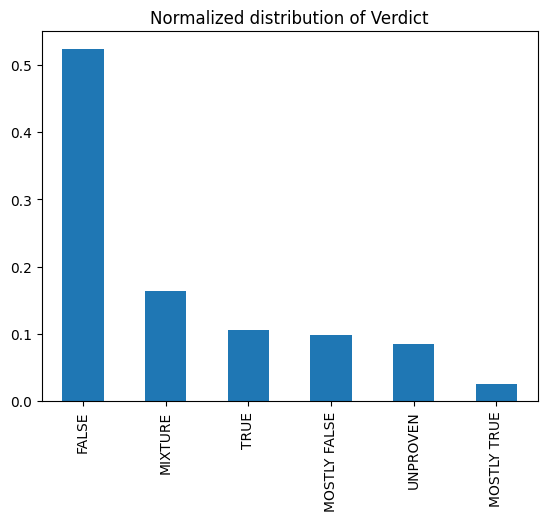

In [28]:
filtered_df['Verdict'].value_counts(normalize=True).plot(kind='bar', title='Normalized distribution of Verdict')

The dataset is very unbalenced in favor of False verdict

In [29]:
filtered_df.sample(5)

,Claim,Verdict,ETS
7287,image depicts hillary clinton supporter standi...,FALSE,hillarys america sheriffclarke pictwittercomkt...
20469,janet reno said gun control waiting periods re...,FALSE,
25612,president trump ordered white house bathed blu...,MIXTURE,
19932,mitch mcconnell consider approving supreme cou...,FALSE,“ american people‎ voice selection next suprem...
13839,video clip shows wrench duplicated 3d printer,TRUE,


### Analysis of ETS column

In [30]:
filtered_df['ets_length'] = filtered_df['ETS'].str.len()
average_text_length_by_verdict = filtered_df.groupby('Verdict')['ets_length'].mean()

<ipython-input-30-e1e9fb25038e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['ets_length'] = filtered_df['ETS'].str.len()


<Axes: xlabel='Verdict'>

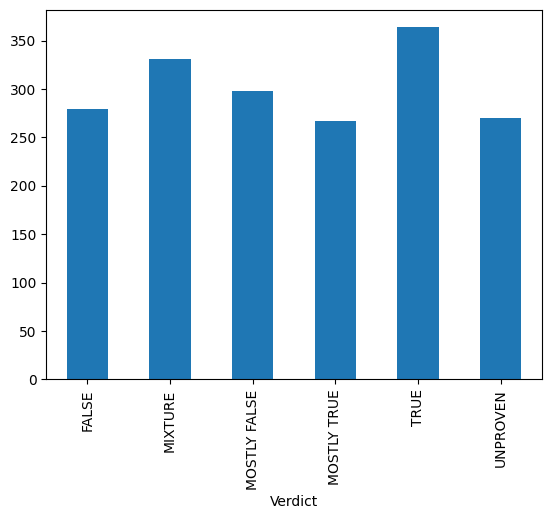

In [31]:
average_text_length_by_verdict.plot(kind='bar')

Each verdict have a more or less close mean in terms of ETS lenght. This means that they each have the same amount of "proof"

In [32]:
def gerenate_worldcloud_ets(verdict, remove_common_words=True):

  ets_string = ' '.join(filtered_df[filtered_df['Verdict']==verdict]['ETS'])

  if remove_common_words:
      common_words = ["said", "say", "one"]
      for word in common_words:
          ets_string = ets_string.replace(word, '')

  wordcloud = WordCloud()
  wordcloud.generate(ets_string)
  plt.imshow(wordcloud.to_image())
  plt.axis('off')
  plt.title('Worldcould for ETS with the verdict: ' + verdict)
  plt.show()

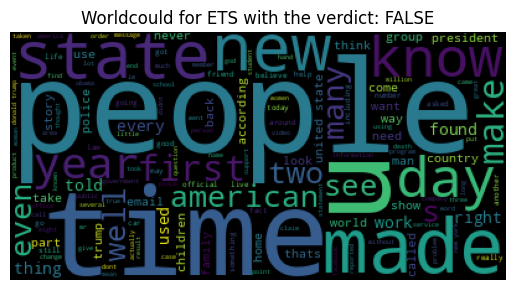

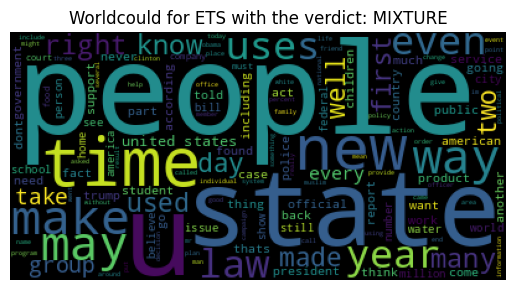

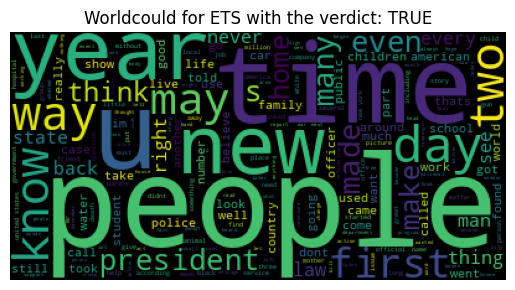

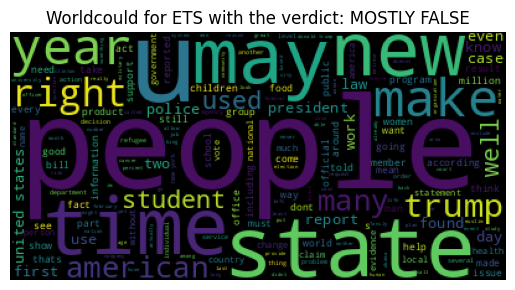

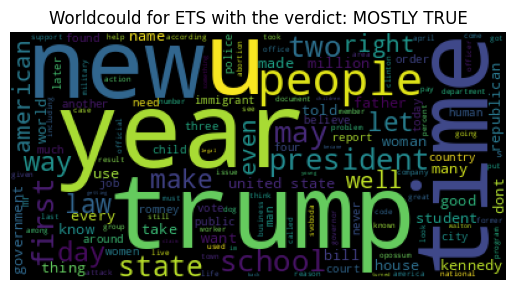

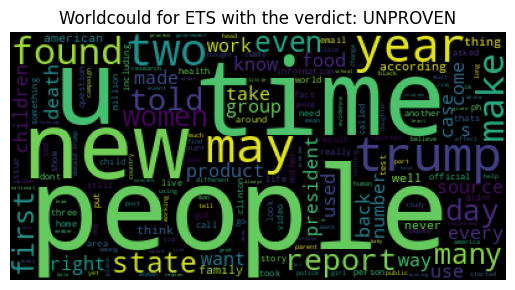

In [33]:
verdicts = ['FALSE', 'MIXTURE', 'TRUE', 'MOSTLY FALSE', 'MOSTLY TRUE', 'UNPROVEN']

for v in verdicts:
  gerenate_worldcloud_ets(v)

In [34]:
def get_top_bigram(verdict, remove_common_words=True, top_n=5):

  ets_string = ' '.join(filtered_df[filtered_df['Verdict']==verdict]['ETS'])

  if remove_common_words:
      common_words = ["said", "say", "one", '“', '”']
      for word in common_words:
          ets_string = ets_string.replace(word, '')

  # Tokenize the text into words
  words = word_tokenize(ets_string.lower())

  # Generate bigrams
  bigrams_list = list(bigrams(words))

  # Count the occurrences of each bigram
  bigram_counts = {}
  for bigram in bigrams_list:
      if bigram in bigram_counts:
          bigram_counts[bigram] += 1
      else:
          bigram_counts[bigram] = 1

  # Get the top N bigrams
  top_bigrams = sorted(bigram_counts.items(), key=lambda x: x[1], reverse=True)[:top_n]

  labels, counts = zip(*[(f"{bigram[0]} {bigram[1]}", count) for bigram, count in top_bigrams])

  # Plot the top bigrams
  plt.figure(figsize=(10, 6))
  plt.barh(labels, counts, color='skyblue')
  plt.xlabel('Frequency')
  plt.ylabel('Bigrams')
  plt.title('Top ' + str(top_n) + ' Bigrams for ETS with '+ verdict +' verdict')
  plt.show()

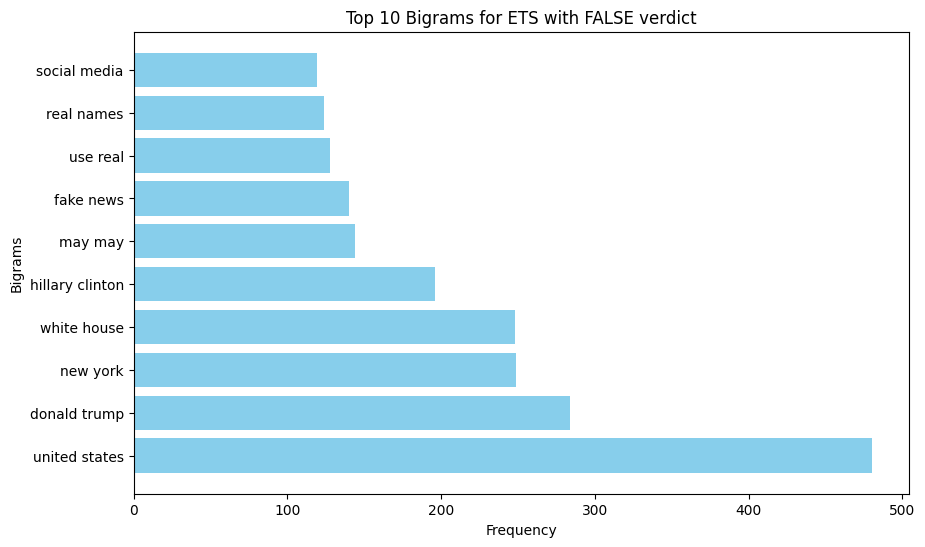

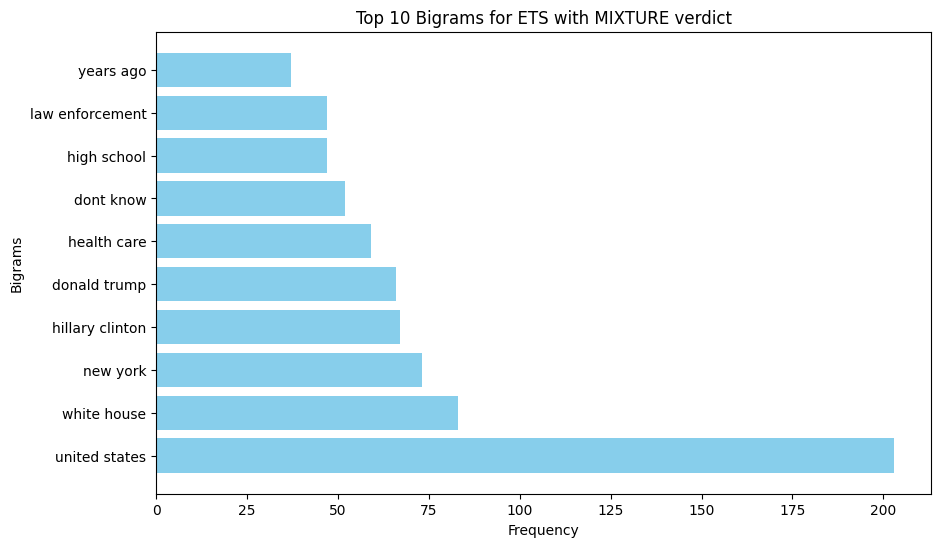

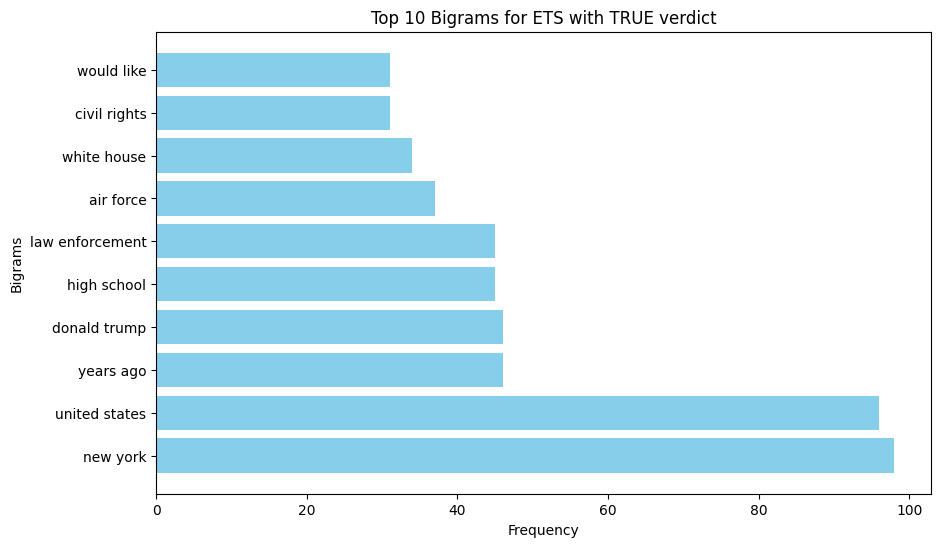

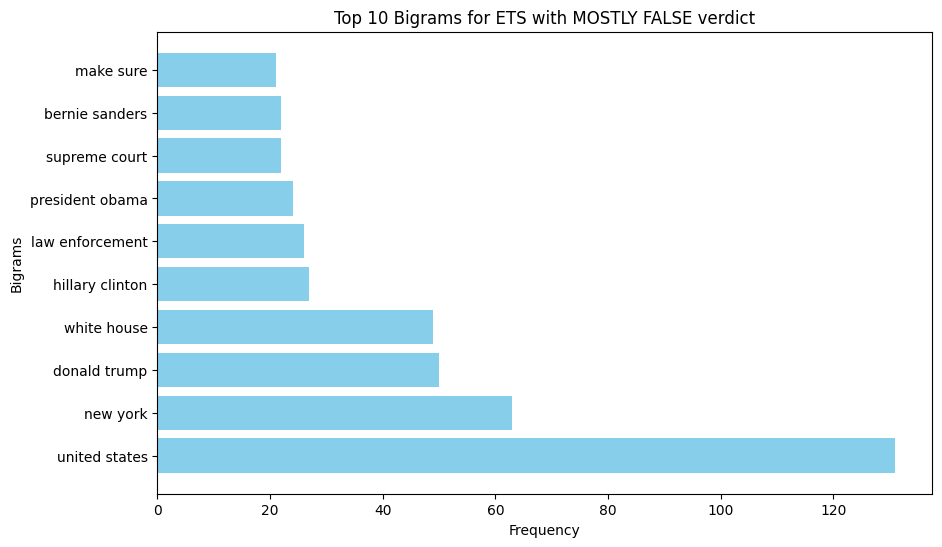

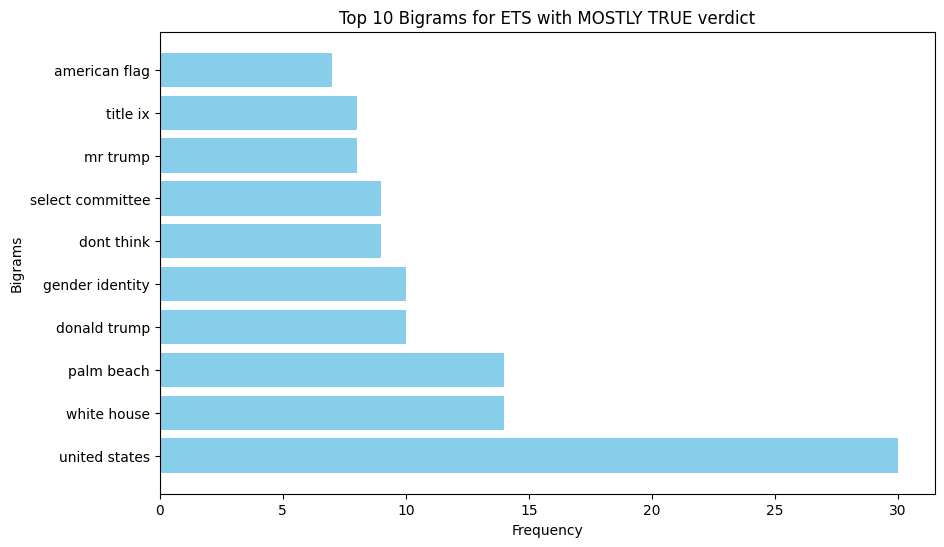

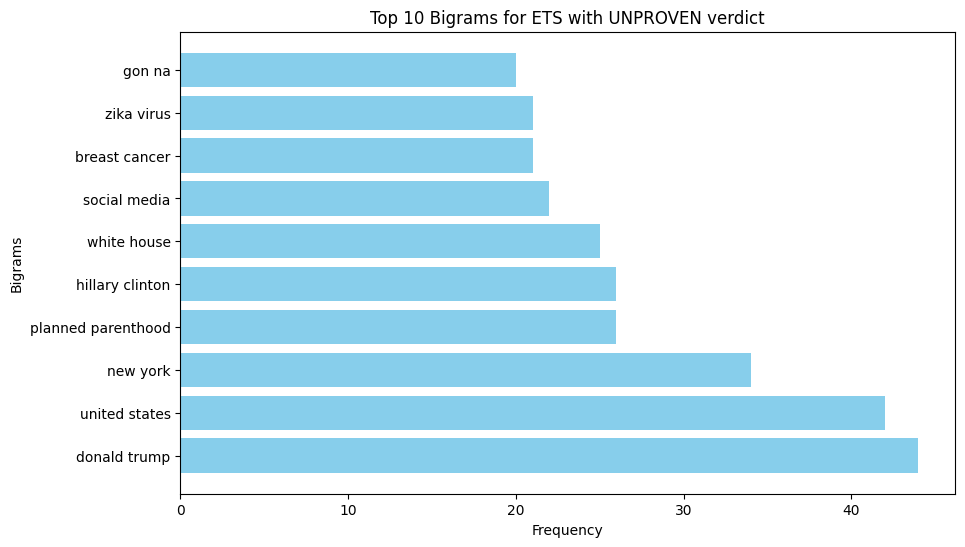

In [35]:
for v in verdicts:
  get_top_bigram(v, top_n=10)

We can see that despite coming from the Snopes fact-checking web-site that treats all kind of facts. The UKP_Snopes dataset mainly consists of ETS related to the United States during the 2019 election compaign as there are no mention of President Biden in the top bigrams

# Bert Tokenizer

Preprocessing the data




In [36]:
df.head()

,Claim,Verdict,ETS,Numerical_Verdict
11,Glen Eagles hospital issued an urgent warning ...,FALSE,"<p>Recently, an email and short message servic...",0
12,Glen Eagles hospital issued an urgent warning ...,FALSE,<p>I can 100% confirm that the text message go...,0
13,Glen Eagles hospital issued an urgent warning ...,FALSE,<p>Gleneagles Hospital Kuala Lumpur has refute...,0
14,A tornado carried a mobile home for 130 miles ...,FALSE,"<p>A family from Tulsa, Oklahoma, underwent th...",0
15,A tornado carried a mobile home for 130 miles ...,FALSE,<p>WNDR assumes however all responsibility for...,0


In [37]:
columns_to_process = ['ETS', 'Claim']

# Use concurrent.futures to run the process in parallel
with concurrent.futures.ThreadPoolExecutor() as executor2:
    # Submit the tasks for each column
    futures = [executor2.submit(apply_preprocessing_with_progress, df, column_name, punctuation=False, stopwords=False) for column_name in columns_to_process]

    # Wait for all tasks to complete
    concurrent.futures.wait(futures)

<ipython-input-24-f9f5a919d4c7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = df[column_name].progress_apply(lambda x: preprocess_text(x, remove_stopwords=stopwords, remove_punctuation=punctuation, remove_html=html))


In [38]:
df.head()

,Claim,Verdict,ETS,Numerical_Verdict
11,glen eagles hospital issued an urgent warning ...,FALSE,"recently, an email and short message service (...",0
12,glen eagles hospital issued an urgent warning ...,FALSE,i can 100% confirm that the text message going...,0
13,glen eagles hospital issued an urgent warning ...,FALSE,gleneagles hospital kuala lumpur has refuted a...,0
14,a tornado carried a mobile home for 130 miles ...,FALSE,"a family from tulsa, oklahoma, underwent the s...",0
15,a tornado carried a mobile home for 130 miles ...,FALSE,wndr assumes however all responsibility for th...,0


In [39]:
rEts = df.loc[df.Verdict == 'TRUE', ['ETS']].sample(10).values
for ets in rEts:
    print(ets[0])

this christmas season, we're sending a message to one of the top corporate supporters of the liberal, lgbt agenda and we need your help. we're shopping #anywherebuttarget because we don't think conservatives should fund target's dangerous social agenda. not only has target publicly advertised that its stores' gender specific facilities-changing rooms and bathrooms-are open to all comers, regardless of biological sex, but target has also stood by the policy, despite falling revenues. it's time to make target understand that there are consequences for supporting a radical movement that is determined to redefine marriage, gender, and, ultimately, the 1st amendment.
we can assure you it was not fake! :) have a look at the behind the scenes video here on emirates' channel to see how it was planned and done!
the workers believe the moose may have come across the sagging and swaying wires and decided to challenge the power line to a fight, as bull moose are known to do during the rut, or mati

### Tokenizer

In [40]:
def tokenize_column(df, column_name, tokenizer):
    # Convert the column to a list
    column_texts = df[column_name].tolist()

    # Tokenize each text
    tokenized_data = [tokenizer(text, truncation=True, padding='max_length', return_tensors = 'tf') for text in column_texts]

    # Add the tokenized data to the DataFrame
    df[column_name + '_tokenized'] = tokenized_data
    return df

In [41]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

df = tokenize_column(df, 'ETS', tokenizer)
df = tokenize_column(df, 'Claim', tokenizer)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

<ipython-input-40-bdac8b32f1f0>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name + '_tokenized'] = tokenized_data
<ipython-input-40-bdac8b32f1f0>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name + '_tokenized'] = tokenized_data


In [42]:
df

,Claim,Verdict,ETS,Numerical_Verdict,ETS_tokenized,Claim_tokenized
11,glen eagles hospital issued an urgent warning ...,FALSE,"recently, an email and short message service (...",0,"[input_ids, token_type_ids, attention_mask]","[input_ids, token_type_ids, attention_mask]"
12,glen eagles hospital issued an urgent warning ...,FALSE,i can 100% confirm that the text message going...,0,"[input_ids, token_type_ids, attention_mask]","[input_ids, token_type_ids, attention_mask]"
13,glen eagles hospital issued an urgent warning ...,FALSE,gleneagles hospital kuala lumpur has refuted a...,0,"[input_ids, token_type_ids, attention_mask]","[input_ids, token_type_ids, attention_mask]"
14,a tornado carried a mobile home for 130 miles ...,FALSE,"a family from tulsa, oklahoma, underwent the s...",0,"[input_ids, token_type_ids, attention_mask]","[input_ids, token_type_ids, attention_mask]"
15,a tornado carried a mobile home for 130 miles ...,FALSE,wndr assumes however all responsibility for th...,0,"[input_ids, token_type_ids, attention_mask]","[input_ids, token_type_ids, attention_mask]"
...,...,...,...,...,...,...
25771,hillary clinton paid an actor to dress up in n...,FALSE,enlisted surface warfare specialist navy/marin...,0,"[input_ids, token_type_ids, attention_mask]","[input_ids, token_type_ids, attention_mask]"
25772,hillary clinton paid an actor to dress up in n...,FALSE,"“oscar without the navy, is like me without a ...",0,"[input_ids, token_type_ids, attention_mask]","[input_ids, token_type_ids, attention_mask]"
25773,hillary clinton paid an actor to dress up in n...,FALSE,uniforms for retired personnel general. retire...,0,"[input_ids, token_type_ids, attention_mask]","[input_ids, token_type_ids, attention_mask]"
25774,hillary clinton paid an actor to dress up in n...,FALSE,now this is even low for the clintons. using a...,0,"[input_ids, token_type_ids, attention_mask]","[input_ids, token_type_ids, attention_mask]"


### Exploring the tokenized dataset

In [43]:
columns_to_print = ['Claim', 'Claim_tokenized', 'ETS', 'ETS_tokenized']

for column in columns_to_print:
    # Get the data for the column
    data = df[column].iloc[0]

    if isinstance(data, str):
      print(f'Column: {column}')
      print(f'Untokenized text ({len(data)}): {data}')
    else:
      # Get the input_ids, token_type_ids, and attention_mask
      input_ids = data['input_ids'][0]
      token_type_ids = data['token_type_ids'][0]
      attention_mask = data['attention_mask'][0]

      # Print the input_ids, token_type_ids, and attention_mask
      print(f'Column: {column}')
      print(f'Input IDs ({len(input_ids)}): {input_ids}')
      print(f'Token Type IDs ({len(token_type_ids)}): {token_type_ids}') #in BERT, all tokens are treated as regular world so only we only have 0's
      print(f'Attention Mask ({len(attention_mask)}): {attention_mask}') # 1 if a regular word, 0 if it is padding
      print('================')


Column: Claim
Untokenized text (129): glen eagles hospital issued an urgent warning because seven women have died after sniffing perfume samples received in the mail. 
Column: Claim_tokenized
Input IDs (512): [  101  8904  8125  2902  3843  2019 13661  5432  2138  2698  2308  2031
  2351  2044 27646 17013  8168  2363  1999  1996  5653  1012   102     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0 

In [44]:
ex = df['Claim_tokenized'].iloc[0]['input_ids'][0]
print(f'Type of {ex} is ---> {type(ex)} ')

Type of [  101  8904  8125  2902  3843  2019 13661  5432  2138  2698  2308  2031
  2351  2044 27646 17013  8168  2363  1999  1996  5653  1012   102     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0 

In [45]:
df_tokenized = df.copy()

In [46]:
df_tokenized.drop('Claim', axis=1, inplace=True)
df_tokenized.drop('Verdict', axis=1, inplace=True)
df_tokenized.drop('ETS', axis=1, inplace=True)

In [47]:
df_tokenized

,Numerical_Verdict,ETS_tokenized,Claim_tokenized
11,0,"[input_ids, token_type_ids, attention_mask]","[input_ids, token_type_ids, attention_mask]"
12,0,"[input_ids, token_type_ids, attention_mask]","[input_ids, token_type_ids, attention_mask]"
13,0,"[input_ids, token_type_ids, attention_mask]","[input_ids, token_type_ids, attention_mask]"
14,0,"[input_ids, token_type_ids, attention_mask]","[input_ids, token_type_ids, attention_mask]"
15,0,"[input_ids, token_type_ids, attention_mask]","[input_ids, token_type_ids, attention_mask]"
...,...,...,...
25771,0,"[input_ids, token_type_ids, attention_mask]","[input_ids, token_type_ids, attention_mask]"
25772,0,"[input_ids, token_type_ids, attention_mask]","[input_ids, token_type_ids, attention_mask]"
25773,0,"[input_ids, token_type_ids, attention_mask]","[input_ids, token_type_ids, attention_mask]"
25774,0,"[input_ids, token_type_ids, attention_mask]","[input_ids, token_type_ids, attention_mask]"


In [48]:
print(df_tokenized['Numerical_Verdict'].value_counts(normalize=False))
print(df_tokenized['Numerical_Verdict'].value_counts(normalize=True))

0    7187
1    2367
2    1636
3    1348
5    1151
4     315
Name: Numerical_Verdict, dtype: int64
0    0.513211
1    0.169023
2    0.116824
3    0.096258
5    0.082191
4    0.022494
Name: Numerical_Verdict, dtype: float64


# Building the BERT Models


![BERT Classifier](https://drive.google.com/uc?export=view&id=1Vs1h_SHk3P1gG6SP9Wsw2vHgmCTPZZ9-)

## SimpleBERTClassifer (one input, Claims or ETS)

In [49]:
class SimpleBertClassifier(tf.keras.Model):
    def __init__(self, num_labels, max_length=128):
        super(SimpleBertClassifier, self).__init__()

        # BERT model layers
        self.bert_model = TFBertModel.from_pretrained('bert-base-uncased')

        # Input layers
        self.input_ids = Input(shape=(max_length, ), dtype=tf.int32, name="input_ids")
        self.attention_mask = Input(shape=(max_length, ), dtype=tf.int32, name="attention_mask")

        # Dense layers for classification
        self.dense1 = Dense(128, activation='relu')
        self.output_layer = Dense(num_labels, activation='softmax')

    def call(self, inputs, training=False):
        # Extract inputs
        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']

        # BERT forward pass
        print(f"Input IDs shape: {input_ids.shape}")
        print(f"Attention Mask shape: {attention_mask.shape}")

        bert_outputs = self.bert_model(input_ids, attention_mask=attention_mask)

        print(f"Bert Outputs keys: {bert_outputs.keys()}")
        pooled_output = bert_outputs.pooler_output

        # Dense layers for classification
        print(f"Pooled Output shape: {pooled_output.shape}")
        dense1_output = self.dense1(pooled_output)
        output = self.output_layer(dense1_output)

        print(f"Output shape: {output.shape}")
        return output

In [50]:
model_claim = SimpleBertClassifier(num_labels=6, max_length=512)
model_ets = SimpleBertClassifier(num_labels=6, max_length=512)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [51]:
model_claim.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model_ets.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [52]:
# Dummy data for building the model
dummy_data = {
    'input_ids': tf.ones((1, 512), dtype=tf.int32),
    'attention_mask': tf.ones((1, 512), dtype=tf.int32)
}

# Call the model on the dummy data to build it
_ = model_claim(dummy_data)
_ = model_ets(dummy_data)


model_claim.summary()
model_ets.summary()

Input IDs shape: (1, 512)
Attention Mask shape: (1, 512)
Bert Outputs keys: odict_keys(['last_hidden_state', 'pooler_output'])
Pooled Output shape: (1, 768)
Output shape: (1, 6)
Input IDs shape: (1, 512)
Attention Mask shape: (1, 512)
Bert Outputs keys: odict_keys(['last_hidden_state', 'pooler_output'])
Pooled Output shape: (1, 768)
Output shape: (1, 6)
Model: "simple_bert_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tf_bert_model (TFBertModel  multiple                  109482240 
 )                                                               
                                                                 
 dense (Dense)               multiple                  98432     
                                                                 
 dense_1 (Dense)             multiple                  774       
                                                                 
Total params: 1095

## DoubleBERTClassifer (two inputs, Claim and ETS)

In [77]:
class DoubleBertClassifier(tf.keras.Model):
    def __init__(self, num_labels, max_length=128):
        super(DoubleBertClassifier, self).__init__()

        # BERT model layers
        self.bert_model = TFBertModel.from_pretrained('bert-base-uncased')

        # Input layers for claim
        self.claim_input_ids = Input(shape=(max_length, ), dtype=tf.int32, name="claim_input_ids")
        self.claim_attention_mask = Input(shape=(max_length, ), dtype=tf.int32, name="claim_attention_mask")

        # Input layers for ETS
        self.ets_input_ids = Input(shape=(max_length, ), dtype=tf.int32, name="ets_input_ids")
        self.ets_attention_mask = Input(shape=(max_length, ), dtype=tf.int32, name="ets_attention_mask")

        # Dense layers for classification
        self.dense1 = Dense(128, activation='relu')
        self.output_layer = Dense(num_labels, activation='softmax')

    def call(self, inputs, training=False):
        # Extract inputs for claim
        claim_input_ids = inputs['claim_input_ids']
        claim_attention_mask = inputs['claim_attention_mask']

        # Extract inputs for ETS
        ets_input_ids = inputs['ets_input_ids']
        ets_attention_mask = inputs['ets_attention_mask']

        # Concate claim and ETS
        concatenated_input_ids = tf.concat([claim_input_ids, ets_input_ids], axis=1)
        concatenated_attention_mask = tf.concat([claim_attention_mask, ets_attention_mask], axis=1)

        # BERT forward pass
        bert_outputs = self.bert_model(concatenated_input_ids, attention_mask=concatenated_attention_mask)
        pooled_output = bert_outputs.pooler_output

        # Dense layers for classification
        dense1_output = self.dense1(pooled_output)
        output = self.output_layer(dense1_output)

        return output

In [78]:
double_model = DoubleBertClassifier(num_labels=6, max_length=512)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [79]:
double_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [80]:
# Dummy data for building the model
dummy_data = {
    'claim_input_ids': tf.ones((1, 512), dtype=tf.int32),
    'claim_attention_mask': tf.ones((1, 512), dtype=tf.int32),
    'ets_input_ids': tf.ones((1, 512), dtype=tf.int32),
    'ets_attention_mask': tf.ones((1, 512), dtype=tf.int32)
}

# Call double_model model on the dummy data to build it
_ = double_model(dummy_data)

# Now you can print the model summary
double_model.summary()

Model: "double_bert_classifier_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tf_bert_model_3 (TFBertMod  multiple                  109482240 
 el)                                                             
                                                                 
 dense_6 (Dense)             multiple                  98432     
                                                                 
 dense_7 (Dense)             multiple                  774       
                                                                 
Total params: 109581446 (418.02 MB)
Trainable params: 109581446 (418.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Splitting the dataset (Claim)

In [57]:
X = pd.DataFrame({
    "Claim_tokenized": df_tokenized["Claim_tokenized"],
    "ETS_tokenized": df_tokenized["ETS_tokenized"]
})
y = df_tokenized["Numerical_Verdict"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [58]:
X

,Claim_tokenized,ETS_tokenized
11,"[input_ids, token_type_ids, attention_mask]","[input_ids, token_type_ids, attention_mask]"
12,"[input_ids, token_type_ids, attention_mask]","[input_ids, token_type_ids, attention_mask]"
13,"[input_ids, token_type_ids, attention_mask]","[input_ids, token_type_ids, attention_mask]"
14,"[input_ids, token_type_ids, attention_mask]","[input_ids, token_type_ids, attention_mask]"
15,"[input_ids, token_type_ids, attention_mask]","[input_ids, token_type_ids, attention_mask]"
...,...,...
25771,"[input_ids, token_type_ids, attention_mask]","[input_ids, token_type_ids, attention_mask]"
25772,"[input_ids, token_type_ids, attention_mask]","[input_ids, token_type_ids, attention_mask]"
25773,"[input_ids, token_type_ids, attention_mask]","[input_ids, token_type_ids, attention_mask]"
25774,"[input_ids, token_type_ids, attention_mask]","[input_ids, token_type_ids, attention_mask]"


In [59]:
print(f'Shape of X:\n{X.shape}')
print(f'Shape of y:\n{y.shape}')
print()
print(f'Shape of X_train:\n{X_train.shape}')
print(f'Shape of y_train:\n{y_train.shape}')
print(f'Shape of X_test:\n{X_test.shape}')
print(f'Shape of y_test:\n{y_test.shape}')
print(f'Shape of X_val:\n{X_val.shape}')
print(f'Shape of y_test:\n{y_val.shape}')

Shape of X:
(14004, 2)
Shape of y:
(14004,)

Shape of X_train:
(8962, 2)
Shape of y_train:
(8962,)
Shape of X_test:
(2801, 2)
Shape of y_test:
(2801,)
Shape of X_val:
(2241, 2)
Shape of y_test:
(2241,)


Transform the tokenized data to the tensors (`tf.int32`) that BERT model requires

In [60]:
def convert_to_tensor(df, token_type):
  converted_tensors = []
  for i in range(len(df)):
    data = df.iloc[i][token_type]
    converted_tensor = tf.convert_to_tensor(data, dtype=tf.int32)
    converted_tensors.append(converted_tensor)
  return tf.concat(converted_tensors, axis=0)

Because we will train both the Simple and Double BERT classifier, we need to separate Claim and ETS.

In [61]:
# Convert tokenized sequences to tensors for training data
train_claim_input_ids = convert_to_tensor(X_train['Claim_tokenized'], token_type='input_ids')
train_claim_attention_mask = convert_to_tensor(X_train['Claim_tokenized'], token_type='attention_mask')

train_ets_input_ids = convert_to_tensor(X_train['ETS_tokenized'], token_type='input_ids')
train_ets_attention_mask = convert_to_tensor(X_train['ETS_tokenized'], token_type='attention_mask')

# Convert tokenized sequences to tensors for validation data
val_claim_input_ids = convert_to_tensor(X_val['Claim_tokenized'], token_type='input_ids')
val_claim_attention_mask = convert_to_tensor(X_val['Claim_tokenized'], token_type='attention_mask')

val_ets_input_ids = convert_to_tensor(X_val['ETS_tokenized'], token_type='input_ids')
val_ets_attention_mask = convert_to_tensor(X_val['ETS_tokenized'], token_type='attention_mask')

# Convert tokenized sequences to tensors for test data
test_claim_input_ids = convert_to_tensor(X_test['Claim_tokenized'], token_type='input_ids')
test_claim_attention_mask = convert_to_tensor(X_test['Claim_tokenized'], token_type='attention_mask')

test_ets_input_ids = convert_to_tensor(X_test['ETS_tokenized'], token_type='input_ids')
test_ets_attention_mask = convert_to_tensor(X_test['ETS_tokenized'], token_type='attention_mask')


### Shape annd Type of training data

In [62]:
print(f'Shape and datatype of Claim Input IDs:\n{train_claim_input_ids.shape}\n{type(train_claim_input_ids)}\n')
print(f'Shape and datatype of Claim Attention Mask:\n{train_claim_attention_mask.shape}\n{type(train_claim_attention_mask)}\n')

print(f'Shape and datatype of ETS Input IDs:\n{train_ets_input_ids.shape}\n{type(train_ets_input_ids)}\n')
print(f'Shape and datatype of ETS Attention Mask:\n{train_ets_attention_mask.shape}\n{type(train_ets_attention_mask)}\n')

print(f'Shape and datatype of y_train:\n{y_train.shape}\n{type(y_train)}')

Shape and datatype of Claim Input IDs:
(8962, 512)
<class 'tensorflow.python.framework.ops.EagerTensor'>

Shape and datatype of Claim Attention Mask:
(8962, 512)
<class 'tensorflow.python.framework.ops.EagerTensor'>

Shape and datatype of ETS Input IDs:
(8962, 512)
<class 'tensorflow.python.framework.ops.EagerTensor'>

Shape and datatype of ETS Attention Mask:
(8962, 512)
<class 'tensorflow.python.framework.ops.EagerTensor'>

Shape and datatype of y_train:
(8962,)
<class 'pandas.core.series.Series'>


### Shape annd Type of validation data

In [63]:
print(f'Shape and datatype of Claim Input IDs:\n{val_claim_input_ids.shape}\n{type(val_claim_input_ids)}\n')
print(f'Shape and datatype of Claim Attention Mask:\n{val_claim_attention_mask.shape}\n{type(val_claim_attention_mask)}\n')

print(f'Shape and datatype of ETS Input IDs:\n{val_ets_input_ids.shape}\n{type(val_ets_input_ids)}\n')
print(f'Shape and datatype of ETS Attention Mask:\n{val_ets_attention_mask.shape}\n{type(val_ets_attention_mask)}\n')

print(f'Shape and datatype of y_val:\n{y_val.shape}\n{type(y_val)}')

Shape and datatype of Claim Input IDs:
(2241, 512)
<class 'tensorflow.python.framework.ops.EagerTensor'>

Shape and datatype of Claim Attention Mask:
(2241, 512)
<class 'tensorflow.python.framework.ops.EagerTensor'>

Shape and datatype of ETS Input IDs:
(2241, 512)
<class 'tensorflow.python.framework.ops.EagerTensor'>

Shape and datatype of ETS Attention Mask:
(2241, 512)
<class 'tensorflow.python.framework.ops.EagerTensor'>

Shape and datatype of y_val:
(2241,)
<class 'pandas.core.series.Series'>


### Shape annd Type of test data

In [64]:
print(f'Shape and datatype of Claim Input IDs:\n{test_claim_input_ids.shape}\n{type(test_claim_input_ids)}\n')
print(f'Shape and datatype of Claim Attention Mask:\n{test_claim_attention_mask.shape}\n{type(test_claim_attention_mask)}\n')

print(f'Shape and datatype of ETS Input IDs:\n{test_ets_input_ids.shape}\n{type(test_ets_input_ids)}\n')
print(f'Shape and datatype of ETS Attention Mask:\n{test_ets_attention_mask.shape}\n{type(test_ets_attention_mask)}\n')

print(f'Shape and datatype of y_test:\n{y_test.shape}\n{type(y_test)}')

Shape and datatype of Claim Input IDs:
(2801, 512)
<class 'tensorflow.python.framework.ops.EagerTensor'>

Shape and datatype of Claim Attention Mask:
(2801, 512)
<class 'tensorflow.python.framework.ops.EagerTensor'>

Shape and datatype of ETS Input IDs:
(2801, 512)
<class 'tensorflow.python.framework.ops.EagerTensor'>

Shape and datatype of ETS Attention Mask:
(2801, 512)
<class 'tensorflow.python.framework.ops.EagerTensor'>

Shape and datatype of y_test:
(2801,)
<class 'pandas.core.series.Series'>


# Hyperparameters

In [65]:
subset_size = 100
batch_size = 10
num_epochs = 6

# SimpleBERTClassifier (Claims)

### Training

RESULTS :

In [66]:
model_claim.fit(
    {'input_ids': train_claim_input_ids, 'attention_mask': train_claim_attention_mask},
    y_train,
    epochs=num_epochs,
    batch_size=batch_size,
)

Epoch 1/6
Input IDs shape: (None, 512)
Attention Mask shape: (None, 512)
Bert Outputs keys: odict_keys(['last_hidden_state', 'pooler_output'])
Pooled Output shape: (None, 768)
Output shape: (None, 6)
Input IDs shape: (None, 512)
Attention Mask shape: (None, 512)
Bert Outputs keys: odict_keys(['last_hidden_state', 'pooler_output'])
Pooled Output shape: (None, 768)
Output shape: (None, 6)
897/897 [==============================] - 294s 276ms/step - loss: 1.1683 - accuracy: 0.5906
Epoch 2/6
897/897 [==============================] - 247s 275ms/step - loss: 0.4861 - accuracy: 0.8455
Epoch 3/6
897/897 [==============================] - 247s 275ms/step - loss: 0.1558 - accuracy: 0.9543
Epoch 4/6
897/897 [==============================] - 246s 275ms/step - loss: 0.0703 - accuracy: 0.9794
Epoch 5/6
897/897 [==============================] - 247s 275ms/step - loss: 0.0367 - accuracy: 0.9898
Epoch 6/6
897/897 [==============================] - 247s 275ms/step - loss: 0.0370 - accuracy: 0.9884


## Evaluate

RESULTS :

In [67]:
evaluation = model_claim.evaluate({'input_ids': val_claim_input_ids, 'attention_mask': val_claim_input_ids},
                            y_val,
                            batch_size=batch_size)
print("Test Loss:", evaluation[0])
print("Test Accuracy:", evaluation[1])

Input IDs shape: (None, 512)
Attention Mask shape: (None, 512)
Bert Outputs keys: odict_keys(['last_hidden_state', 'pooler_output'])
Pooled Output shape: (None, 768)
Output shape: (None, 6)
225/225 [==============================] - 25s 99ms/step - loss: 5.7325 - accuracy: 0.0986
Test Loss: 5.732549667358398
Test Accuracy: 0.09861668944358826


## Prediction

RESULTS :

In [68]:
# Using the model to make predictions on validation data
predictions = model_claim.predict({'input_ids': test_claim_input_ids, 'attention_mask': test_claim_attention_mask})
predicted_labels = np.argmax(predictions, axis=1)

accuracy = accuracy_score(y_test, predicted_labels)
print(f'Accuracy: {accuracy:.4f}')

# Generate a classification report
print('Classification Report:')
print(classification_report(y_test, predicted_labels))

# Generate a confusion matrix
conf_mat = confusion_matrix(y_test, predicted_labels)
print('Confusion Matrix:')
print(conf_mat)

Input IDs shape: (None, 512)
Attention Mask shape: (None, 512)
Bert Outputs keys: odict_keys(['last_hidden_state', 'pooler_output'])
Pooled Output shape: (None, 768)
Output shape: (None, 6)
88/88 [==============================] - 27s 271ms/step
Accuracy: 0.8972
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92      1447
           1       0.88      0.90      0.89       490
           2       0.88      0.80      0.84       330
           3       0.81      0.94      0.87       263
           4       0.95      0.80      0.87        69
           5       0.90      0.87      0.88       202

    accuracy                           0.90      2801
   macro avg       0.89      0.87      0.88      2801
weighted avg       0.90      0.90      0.90      2801

Confusion Matrix:
[[1328   40   27   37    1   14]
 [  21  443    7   14    0    5]
 [  43   17  264    3    2    1]
 [  13    2    1  247    0    0]
 [  11    1    0    2

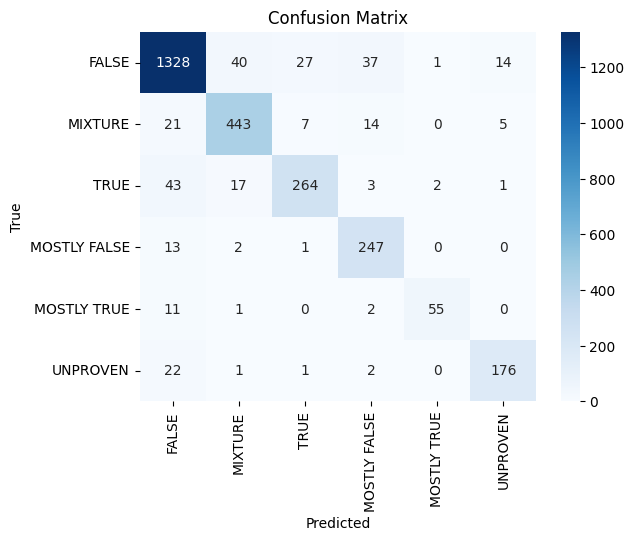

In [69]:
# Plot the confusion matrix with axis labels using seaborn
labels = list(verdict_mapping.keys())
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [70]:
model_claim.save("SimpleBERTClassifier_Claim", save_format="tf")

Input IDs shape: (None, 512)
Attention Mask shape: (None, 512)
Bert Outputs keys: odict_keys(['last_hidden_state', 'pooler_output'])
Pooled Output shape: (None, 768)
Output shape: (None, 6)
Input IDs shape: (None, 512)
Attention Mask shape: (None, 512)
Bert Outputs keys: odict_keys(['last_hidden_state', 'pooler_output'])
Pooled Output shape: (None, 768)
Output shape: (None, 6)
Input IDs shape: (None, 512)
Attention Mask shape: (None, 512)
Bert Outputs keys: odict_keys(['last_hidden_state', 'pooler_output'])
Pooled Output shape: (None, 768)
Output shape: (None, 6)


# SimpleBERTClassifier (ETS)

## Training

RESULTS :

In [71]:
model_ets.fit(
    {'input_ids': train_ets_input_ids, 'attention_mask': train_ets_attention_mask},
    y_train,
    epochs=num_epochs,
    batch_size=batch_size,
)

Epoch 1/6
Input IDs shape: (None, 512)
Attention Mask shape: (None, 512)
Bert Outputs keys: odict_keys(['last_hidden_state', 'pooler_output'])
Pooled Output shape: (None, 768)
Output shape: (None, 6)
Input IDs shape: (None, 512)
Attention Mask shape: (None, 512)
Bert Outputs keys: odict_keys(['last_hidden_state', 'pooler_output'])
Pooled Output shape: (None, 768)
Output shape: (None, 6)
897/897 [==============================] - 292s 281ms/step - loss: 1.3633 - accuracy: 0.5069
Epoch 2/6
897/897 [==============================] - 248s 276ms/step - loss: 1.1484 - accuracy: 0.5722
Epoch 3/6
897/897 [==============================] - 247s 275ms/step - loss: 0.7055 - accuracy: 0.7508
Epoch 4/6
897/897 [==============================] - 247s 275ms/step - loss: 0.2880 - accuracy: 0.9068
Epoch 5/6
897/897 [==============================] - 247s 275ms/step - loss: 0.1186 - accuracy: 0.9641
Epoch 6/6
897/897 [==============================] - 247s 275ms/step - loss: 0.0798 - accuracy: 0.9746


~~Training accuracy and loss ~~

 ~~**With 3 epochs :**~~

~~Contrary to the model using only the Claims, it seems it is harder to train the model with only the ETS. The accuracy did increase quite a lot between the first and third epoch however, going from 50.58% to 72.32%. Increasing the number should therefore increase the accuracy~~

~~**With 6 epochs :**~~

~~As excpected, increasing the number of epochs did improve the accuracy and the loss consideratly. From the fourth epoch already we went from 78.29% to 91.73% ! On the fifth epoch we have loss of 0.1146 and an accuracy 96.57% (we had a similar result on the third epochs using only the Claims) **On the sixth and final epochs, we get an accuracy of 97.55% and a loss of 0.0816**~~

~~ETS being more diverse than claims (There can be the same claim many times in the dataset with different ETS), it makes sense that this version of the model took a longer time reach a decent accuracy and loss. It also means it should work better on a more wide range of new input data !~~

## Evaluate

RESULTS :

In [72]:
evaluation = model_ets.evaluate({'input_ids': val_ets_input_ids, 'attention_mask': val_ets_attention_mask},
                            y_val,
                            batch_size=batch_size)
print("Test Loss:", evaluation[0])
print("Test Accuracy:", evaluation[1])

Input IDs shape: (None, 512)
Attention Mask shape: (None, 512)
Bert Outputs keys: odict_keys(['last_hidden_state', 'pooler_output'])
Pooled Output shape: (None, 768)
Output shape: (None, 6)
225/225 [==============================] - 27s 100ms/step - loss: 2.2202 - accuracy: 0.5913
Test Loss: 2.2202389240264893
Test Accuracy: 0.5912538766860962


~~Accuracy and loss on the validation set~~

~~**Results after 3 epochs :**~~

~~As expected with the training results, the accuracy is only 56.72% and the loss is quite high (1.2531) with the validation set so we definitly need to tune the hyperparameters before predicting the test set.~~

~~**Results after 6 epochs :**~~

~~Despite increasing the number of epochs and getting a much higher accuracy during training (97.55%) the accuracy for the validation set is still low (55.29%) and the loss (2.1803) is even higher than during the 3 epochs. Again, this could be because the ETS are more diverse than the Claims.~~

~~**Maybe it would be more interesting to do the evaluation on the Claims rather than the ETS as in practice the model is supposed to predict the credibility of a claim.**~~


## Prediction

RESULTS :


In [73]:
# Using the model to make predictions on validation data
predictions = model_ets.predict({'input_ids': test_ets_input_ids, 'attention_mask': test_ets_attention_mask})
predicted_labels = np.argmax(predictions, axis=1)

accuracy = accuracy_score(y_test, predicted_labels)
print(f'Accuracy: {accuracy:.4f}')

# Generate a classification report
print('Classification Report:')
print(classification_report(y_test, predicted_labels))

# Generate a confusion matrix
conf_mat = confusion_matrix(y_test, predicted_labels)
print('Confusion Matrix:')
print(conf_mat)

Input IDs shape: (None, 512)
Attention Mask shape: (None, 512)
Bert Outputs keys: odict_keys(['last_hidden_state', 'pooler_output'])
Pooled Output shape: (None, 768)
Output shape: (None, 6)
88/88 [==============================] - 27s 271ms/step
Accuracy: 0.5616
Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.81      0.73      1447
           1       0.42      0.33      0.37       490
           2       0.41      0.28      0.33       330
           3       0.39      0.24      0.30       263
           4       0.22      0.16      0.19        69
           5       0.36      0.33      0.34       202

    accuracy                           0.56      2801
   macro avg       0.41      0.36      0.38      2801
weighted avg       0.53      0.56      0.54      2801

Confusion Matrix:
[[1177   97   65   43   18   47]
 [ 218  163   35   38    9   27]
 [ 154   57   93    7    3   16]
 [ 120   36   16   63    4   24]
 [  33   14    8    2

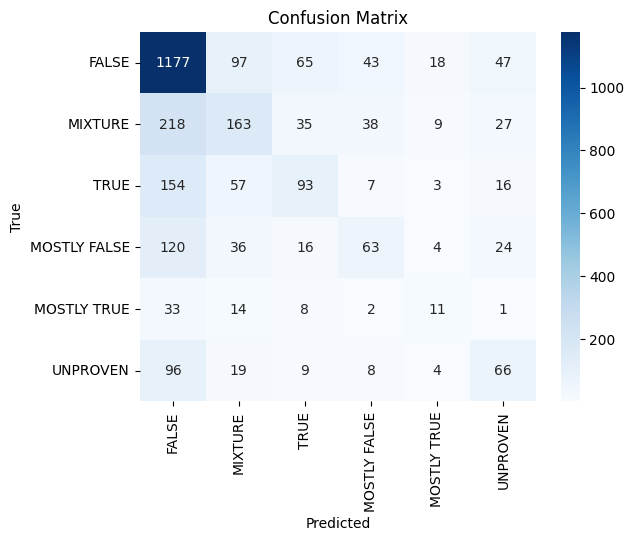

In [74]:
# Plot the confusion matrix with axis labels using seaborn
labels = list(verdict_mapping.keys())
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [87]:
model_ets.save("SimpleBERTClassifier_ETS", save_format="tf")

Input IDs shape: (None, 512)
Attention Mask shape: (None, 512)
Bert Outputs keys: odict_keys(['last_hidden_state', 'pooler_output'])
Pooled Output shape: (None, 768)
Output shape: (None, 6)
Input IDs shape: (None, 512)
Attention Mask shape: (None, 512)
Bert Outputs keys: odict_keys(['last_hidden_state', 'pooler_output'])
Pooled Output shape: (None, 768)
Output shape: (None, 6)
Input IDs shape: (None, 512)
Attention Mask shape: (None, 512)
Bert Outputs keys: odict_keys(['last_hidden_state', 'pooler_output'])
Pooled Output shape: (None, 768)
Output shape: (None, 6)


# DoubleBERTClassifier (Claims & ETS)

## Training

RESULTS :

In [81]:
double_model.fit(
    {'claim_input_ids': train_claim_input_ids,
    'claim_attention_mask': train_claim_attention_mask,
    'ets_input_ids': train_ets_input_ids,
    'ets_attention_mask': train_ets_attention_mask},
    y_train,
    epochs=num_epochs,
    batch_size=batch_size,
)

Epoch 1/6
897/897 [==============================] - 591s 612ms/step - loss: 1.3893 - accuracy: 0.5115
Epoch 2/6
897/897 [==============================] - 548s 611ms/step - loss: 0.9703 - accuracy: 0.6590
Epoch 3/6
897/897 [==============================] - 548s 611ms/step - loss: 0.3459 - accuracy: 0.8903
Epoch 4/6
897/897 [==============================] - 548s 611ms/step - loss: 0.1086 - accuracy: 0.9685
Epoch 5/6
897/897 [==============================] - 548s 610ms/step - loss: 0.0511 - accuracy: 0.9854
Epoch 6/6
897/897 [==============================] - 548s 610ms/step - loss: 0.0298 - accuracy: 0.9907


## Evaluate

RESULTS :

In [82]:
evaluation = double_model.evaluate({'claim_input_ids': val_claim_input_ids,
                                  'claim_attention_mask': val_claim_attention_mask,
                                  'ets_input_ids': val_ets_input_ids,
                                  'ets_attention_mask': val_ets_attention_mask},
                            y_val,
                            batch_size=batch_size)
print("Test Loss:", evaluation[0])
print("Test Accuracy:", evaluation[1])

225/225 [==============================] - 51s 212ms/step - loss: 0.6507 - accuracy: 0.8858
Test Loss: 0.6507292985916138
Test Accuracy: 0.8857652544975281


## Prediction

RESULTS :

In [83]:
# Using the model to make predictions on validation data
predictions = double_model.predict({'claim_input_ids': test_claim_input_ids,
                                  'claim_attention_mask': test_claim_attention_mask,
                                  'ets_input_ids': test_ets_input_ids,
                                  'ets_attention_mask': test_ets_attention_mask})
predicted_labels = np.argmax(predictions, axis=1)

accuracy = accuracy_score(y_test, predicted_labels)
print(f'Accuracy: {accuracy:.4f}')

# Generate a classification report
print('Classification Report:')
print(classification_report(y_test, predicted_labels))

# Generate a confusion matrix
conf_mat = confusion_matrix(y_test, predicted_labels)
print('Confusion Matrix:')
print(conf_mat)

88/88 [==============================] - 58s 620ms/step
Accuracy: 0.8933
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.91      0.92      1447
           1       0.86      0.90      0.88       490
           2       0.81      0.82      0.82       330
           3       0.96      0.89      0.92       263
           4       0.89      0.81      0.85        69
           5       0.84      0.88      0.86       202

    accuracy                           0.89      2801
   macro avg       0.88      0.87      0.87      2801
weighted avg       0.89      0.89      0.89      2801

Confusion Matrix:
[[1321   46   44    8    3   25]
 [  30  440   13    1    2    4]
 [  37   16  272    0    2    3]
 [  13    9    5  235    0    1]
 [  11    1    1    0   56    0]
 [  21    0    1    2    0  178]]


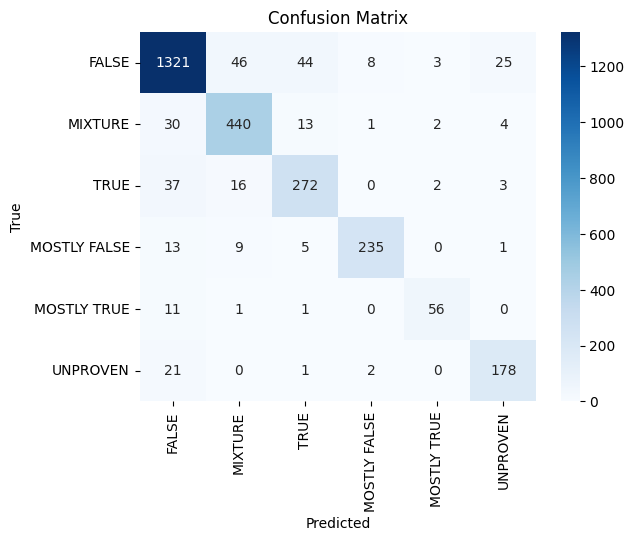

In [84]:
# Plot the confusion matrix with axis labels using seaborn
labels = list(verdict_mapping.keys())
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [86]:
double_model.save("DoubleBERTClassifier", save_format="tf")

# Might use this later



loading a model

In [ ]:
loaded_model = tf.keras.models.load_model("my_BERTClassifier")

Sliding window for documents

In [ ]:
# Creates overlapping windows of tokenized text for a given input text using a sliding window approach.
# This is done because a lot of the text data exeeds the maximum lenght accepted by the tokenizer
def sliding_window(text, tokenizer, window_size=512, stride=256):
    tokens = tokenizer(text, padding=True, truncation=True, return_tensors='pt')['input_ids']
    total_length = tokens.size(1)

     # If the text is shorter than window_size, create a window without padding
    if total_length <= window_size:
        # Adjust the window_size to the actual length of the text
        windows = [tokens[:, :total_length]]
    else:
        # Create windows with the specified stride
        windows = [tokens[:, i:i+window_size] for i in range(0, total_length, stride) if i+window_size <= total_length]

    return windows

In [ ]:
# Function to process sliding windows for a dataset
def process_windows(df, data_windows, tokenizer, stride=256, window_size=512):
    pbar = tqdm(total=len(df), desc=f"Processing {df.name}", position=0, leave=False)
    for i, text in enumerate(df):
        try:
            windows = sliding_window(text, tokenizer, window_size, stride)
            data_windows.extend(windows)
            pbar.update()
        except Exception as e:
            print(f"An error occurred: {e}")
    pbar.close()

model training ober subsets

In [ ]:
subset_input_ids = train_input_ids[:subset_size]
subset_attention_mask = train_attention_mask[:subset_size]
subset_labels = y_train[:subset_size]

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}:")
    for i in range(subset_size // batch_size):
        start = i * batch_size
        end = (i + 1) * batch_size

        subset_batch_input_ids = subset_input_ids[start:end]
        subset_batch_attention_mask = subset_attention_mask[start:end]
        subset_batch_labels = subset_labels[start:end]

        # Train the model on the subset batch
        model.fit(
            {'input_ids': subset_batch_input_ids, 'attention_mask': subset_batch_attention_mask},
            subset_batch_labels,
            epochs=1,
            batch_size=batch_size
        )

        # Manually release memory and forces garbage collection
        del subset_batch_input_ids
        del subset_batch_attention_mask
        del subset_batch_labels
        gc.collect()

model.summary()